# Algorytm Kirkpatricka

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kirkpatrick_algorithm.visualizer.main import Visualizer
import random as rnd_gen
from enum import Enum
from sortedcontainers import SortedSet
import matplotlib
from scipy.spatial import Delaunay,delaunay_plot_2d

# Funkcje rysujące

In [2]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_point(polygon)
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [3]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [4]:
def draw_polygon_colors_dict(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in polygon:
        if colors[i]==0:
            points_start.append(i)
        elif colors[i]==1:
            points_end.append(i)
        elif colors[i]==2:
            points_connect.append(i)
        elif colors[i]==3:
            points_divide.append(i)
        elif colors[i]==4:
            points_regular.append(i)

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [5]:
def draw_polygon_triangulation(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)

    for a, b in tri:
        vis.add_line_segment([polygon[a], polygon[b]], color='red')
    vis.show()

In [6]:
def draw_polygon_tri(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

# Przykładowe wielokąty

In [7]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

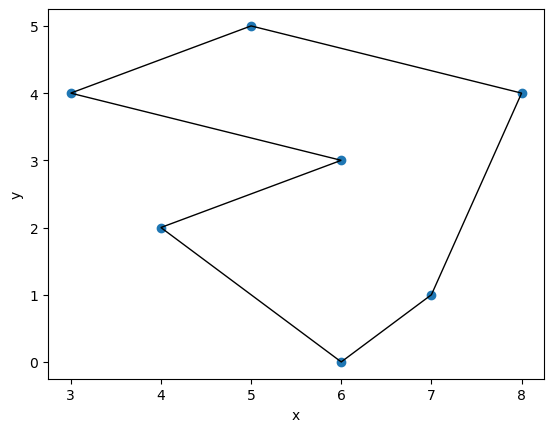

In [8]:
draw_polygon(polygon_example_1)

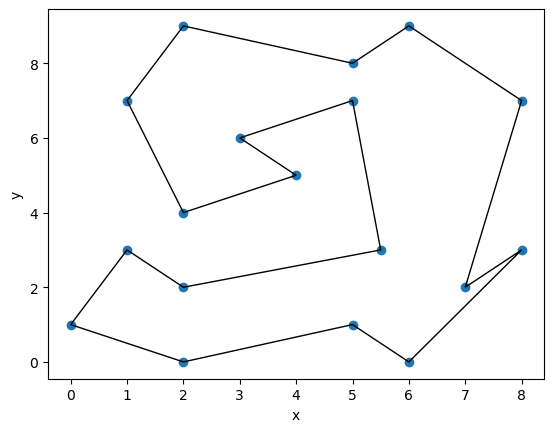

In [9]:
draw_polygon(polygon_example_2)

# Funkcja pozwalająca zadać wielokąt myszką

In [10]:
def get_polygon_points(max_x, max_y, points_data):
    %matplotlib inline
    fig = plt.figure()
    fig.set_label('Polygon Points')
    ax = fig.add_subplot(111)
    ax.set_title(f"Please select points for the polygon in counter-clockwise order")
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])

    cid = None

    def onclick(event):
        plt.plot(event.xdata, event.ydata, 'bo')
        points_data.append((event.xdata, event.ydata))
        ax.annotate(f"{len(points_data)}", xy=(event.xdata, event.ydata))
        fig.canvas.draw()

    def on_close(event):
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)
        %matplotlib inline
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    cid = fig.canvas.mpl_connect('close_event', on_close)
    plt.show()

In [17]:
polygon = []
get_polygon_points(10, 10, polygon)

In [40]:
print(polygon)

[]


# Triangulacja wielokąta

## Funkcja określająca rodzaj wierzchołków 

In [22]:
def draw_triangulation_from_triangles(polygon, triangles : Delaunay):
    vis = Visualizer()
    for a, b, c in triangles.simplices:
        vis.add_polygon([polygon[a], polygon[b], polygon[c]], fill=False)
    vis.add_polygon(polygon, fill=False, color="blue")
    return vis

In [15]:
triangulation_example_1 = Delaunay(polygon_example_1)
print(triangulation_example_1.simplices)

[[0 2 6]
 [2 5 6]
 [0 3 2]
 [3 0 1]
 [3 5 2]
 [5 3 4]]


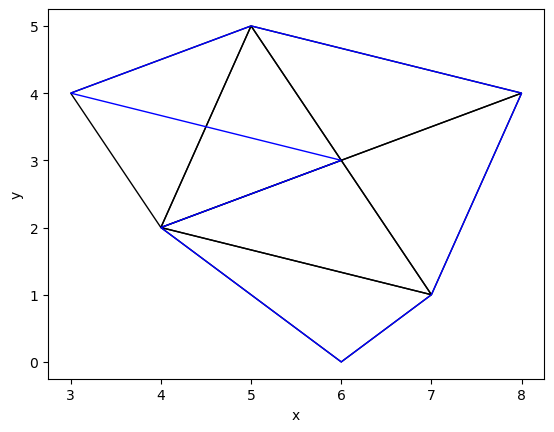

In [23]:
tri_vis_1 = draw_triangulation_from_triangles(polygon_example_1, triangulation_example_1)
tri_vis_1.show()

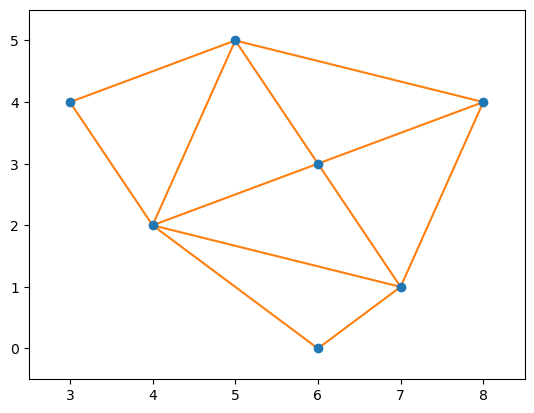

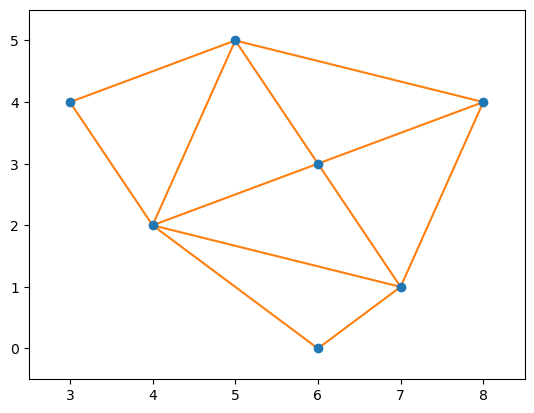

In [26]:
delaunay_plot_2d(triangulation_example_1)

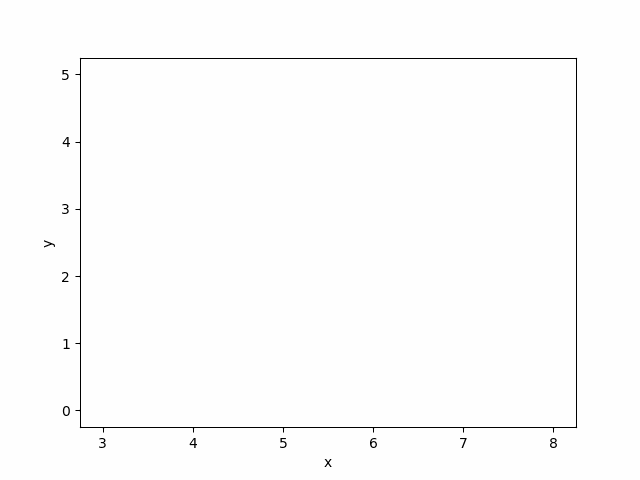

In [20]:
tri_vis_1.show_gif()

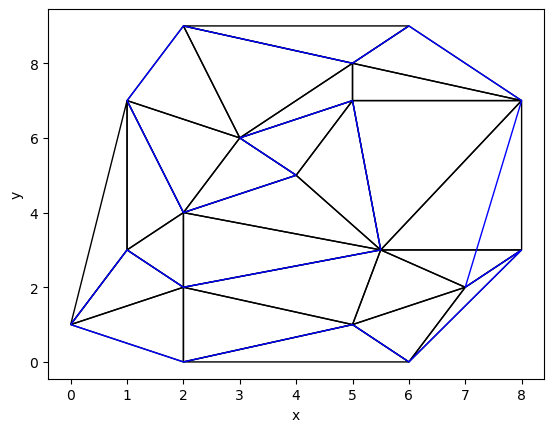

In [27]:
triangulation_example_2 = Delaunay(polygon_example_2)
tri_vis_2 = draw_triangulation_from_triangles(polygon_example_2, triangulation_example_2)
tri_vis_2.show()

## Konwersja polygonu do formatu podwójnie łączonej listy krawędzi

In [90]:
class Vertex:
    def __init__(self):
        self.point_coords = None
        self.incident_halfedge = None
        self.index = -1

    def __str__(self):
        return str(self.point_coords)

In [85]:
class HalfEdge:
    def __init__(self):
        self.prev:HalfEdge = None
        self.next: HalfEdge = None
        self.twin: HalfEdge = None
        self.origin: Vertex = None
        self.incident_face = None
    
    def __str__(self):
        return str(self.origin)

In [86]:
class Face:
    def __init__(self):
        self.incident_edge: HalfEdge = None

In [140]:
def get_doubly_connected_edge_list(polygon):
    N = len(polygon)

    vertices = []
    for i in range(N):
        vertex = Vertex()
        vertex.point_coords = polygon[i]
        vertex.index = i
        vertices.append(vertex)


    f1 = lambda x: x + 1 if -1 <= x <= 0 else (-x + 1 if 0 <= x <= 1 else 0)
    f2 = lambda x: x  if 0 <= x <= 1 else (-x + 2 if 1 <= x <= 2 else 0)
    f = lambda x: f1(x)*f2(x)
    

    halfedges = []

    for i in range(N):
        current_halfedge = HalfEdge()
        current_halfedge.origin = vertices[i]
        current_halfedge.origin.incident_halfedge = current_halfedge
        
        opposite_halfedge = HalfEdge()
        opposite_halfedge.origin = vertices[i-1]
        opposite_halfedge.origin.incident_halfedge = opposite_halfedge

        current_halfedge.twin = opposite_halfedge
        opposite_halfedge.twin = current_halfedge

        halfedges.append(current_halfedge)


    for i in range(N - 1, -1, -1):
        e1, e2 = halfedges[i], halfedges[i - 1]
        e2.twin.next = e2.twin
        e2.prev = e1.twin

    face = Face()
    face.incident_edge = halfedges[0]

    return face
            

In [141]:
face = get_doubly_connected_edge_list(polygon_example_1)

In [142]:
def traverse(face: Face):
    e = face.incident_edge
    start_e = e
    vis = Visualizer()
    while True:
        vis.add_point(e.origin.point_coords)
        vis.show()
        e = e.next

        if e is start_e:
            break

    return vis

AttributeError: 'NoneType' object has no attribute 'origin'

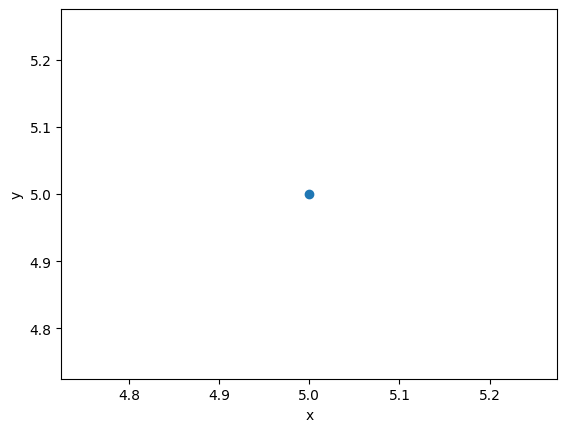

In [143]:
vis = traverse(face)

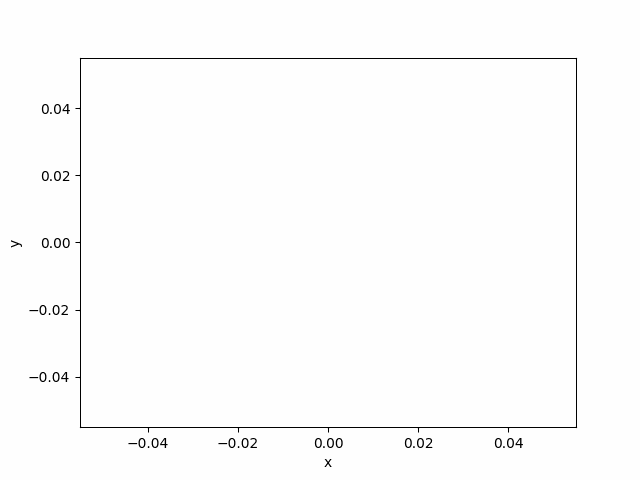

In [132]:
vis.show_gif()